In [1]:
import sys
sys.path.append('/home/sharedrive/nafi/traffic/lib/python3.9/site-packages')

import pandas as pd
from chronos import ChronosPipeline
import torch
from table_evaluator import TableEvaluator
import matplotlib.pyplot as plt
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata
import numpy as np
from ctgan import CTGAN
from ctgan import load_demo
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from table_evaluator import TableEvaluator
import pickle
import os
import time

In [2]:
itu_train_df = pd.read_csv("./datasets/feature_selected_itu_train.csv")
itu_train_df.head()

,Flow_Duration,Total_Length_of_Bwd_Packets,Bwd_Packet_Length_Max,Bwd_Packet_Length_Mean,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,...,Fwd_Packets/s,Bwd_Packets/s,Max_Packet_Length,Packet_Length_Mean,Average_Packet_Size,Avg_Bwd_Segment_Size,Subflow_Bwd_Bytes,Init_Win_bytes_forward,min_seg_size_forward,Label
0,68855579.0,11595.0,4344.0,1932.5,1.834710e+02,0.232370,4.590372e+06,1.760000e+07,68300000.0,2.0,...,0.145232,0.087139,4344.0,743.117647,789.562500,1932.5,11595.0,251.0,32.0,DoS_Hulk
1,196.0,174.0,87.0,87.0,1.244898e+06,20408.163270,6.533333e+01,1.079645e+02,190.0,3.0,...,10204.081630,10204.081630,87.0,55.800000,69.750000,87.0,174.0,-1.0,32.0,BENIGN
2,118.0,96.0,48.0,48.0,1.627119e+06,33898.305080,3.933333e+01,6.206717e+01,111.0,3.0,...,16949.152540,16949.152540,48.0,48.000000,60.000000,48.0,96.0,-1.0,20.0,BENIGN
3,295657.0,15841.0,2920.0,1584.1,5.734686e+04,57.499061,1.847856e+04,5.298594e+04,209299.0,1.0,...,23.676084,33.822977,2920.0,941.944444,997.352941,1584.1,15841.0,8192.0,20.0,BENIGN
4,15705351.0,452.0,220.0,90.4,5.469473e+01,0.764071,1.427759e+06,3.221493e+06,9767208.0,82.0,...,0.445708,0.318363,377.0,66.076923,71.583333,90.4,452.0,8192.0,20.0,BENIGN


In [3]:
itu_test_df = pd.read_csv("./datasets/feature_selected_itu_test.csv")
itu_test_df.head()

,Flow_Duration,Total_Length_of_Bwd_Packets,Bwd_Packet_Length_Max,Bwd_Packet_Length_Mean,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,...,Fwd_Packets/s,Bwd_Packets/s,Max_Packet_Length,Packet_Length_Mean,Average_Packet_Size,Avg_Bwd_Segment_Size,Subflow_Bwd_Bytes,Init_Win_bytes_forward,min_seg_size_forward,Label
0,998.0,0.0,0.0,0.0,0.000000e+00,2004.008016,9.980000e+02,0.000000e+00,998.0,998.0,...,2004.008016,0.000000,0.0,0.0,0.00,0.0,0.0,251.0,32.0,DoS_Hulk
1,63111103.0,0.0,0.0,0.0,0.000000e+00,0.110916,1.050000e+07,1.190000e+07,32100000.0,999612.0,...,0.110916,0.000000,0.0,0.0,0.00,0.0,0.0,29200.0,40.0,DoS_Slowhttptest
2,202.0,130.0,65.0,65.0,1.128713e+06,19801.980200,6.733333e+01,3.348632e+01,106.0,48.0,...,9900.990099,9900.990099,65.0,55.4,69.25,65.0,130.0,-1.0,20.0,BENIGN
3,3.0,0.0,0.0,0.0,0.000000e+00,666666.666700,3.000000e+00,0.000000e+00,3.0,3.0,...,666666.666700,0.000000,0.0,0.0,0.00,0.0,0.0,274.0,32.0,DoS_Hulk
4,37.0,6.0,6.0,6.0,1.621622e+05,54054.054050,3.700000e+01,0.000000e+00,37.0,37.0,...,27027.027030,27027.027030,6.0,2.0,3.00,6.0,6.0,29200.0,40.0,PortScan


In [4]:
itu_train_df.shape, itu_test_df.shape

((1781545, 25), (511540, 25))

In [5]:
label_encoder = LabelEncoder()
scaler = StandardScaler()

In [6]:
def generate_data_for_classes_ctgan(df, classes, num_samples, num_epochs=500):
    synthetic_data = pd.DataFrame()
    for cls in classes:
        selected_df = df[df["Label"] == cls]
        ctgan = CTGAN(epochs=num_epochs, verbose=True)
        ctgan.fit(selected_df, list(selected_df.columns))
        samples = ctgan.sample(num_samples)
        
        synthetic_data = pd.concat([synthetic_data, samples])
    return synthetic_data

In [7]:
small_classes = ['Web_Attack__XSS', 'Web_Attack__Brute_Force',
       'Web_Attack__Sql_Injection', 'Infiltration', 'Heartbleed', 'Bot']

def save_label_encoder(le, file_name):
    with open(f'./models/{file_name}_label_encoder.pkl', 'wb') as le_file:
        pickle.dump(label_encoder, le_file)

def save_scaler(scaler, file_name):
    with open(f'./models/{file_name}_scaler.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)
    
def ctgan_train(train_df, epochi, file_name, reduced_test_df, rounds=0):
    for num_sample in [1000]:
        print(f"{file_name} epoch={epochi} samples={num_sample} round={rounds}")

        synthetic_file_path = f"./datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv"
        
        if os.path.exists(synthetic_file_path):
            print(f"Synthetic data already exists: {synthetic_file_path}")
            synthetic_data_df = pd.read_csv(synthetic_file_path)
        else:
            start_time = time.time()
            print("Generating synthetic data...") 
            synthetic_data = generate_data_for_classes_ctgan(train_df, small_classes, num_sample, epochi)

            # save and load synthetic data
            synthetic_data.to_csv(f'./datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv', index=False)
            synthetic_data_df = pd.read_csv(synthetic_file_path)
            
            elapsed_time = time.time() - start_time
            print(f"Execution time for generating data: {elapsed_time:.2f} seconds")

        # combine synthetic and real data
        combined_train_synth_df = pd.concat([train_df, synthetic_data_df], axis=0, ignore_index=True)

        # divide to x_train and y_train from reduced_train_df
        x_train = combined_train_synth_df.drop(columns=["Label"])
        y_train = combined_train_synth_df["Label"]
        x_test = reduced_test_df.drop(columns=["Label"])
        y_test = reduced_test_df["Label"]
        
        y_train = label_encoder.fit_transform(y_train) # Encode string labels into numeric format
        y_test = label_encoder.transform(y_test)
        x_train = scaler.fit_transform(x_train) # Standardize the features
        x_test = scaler.transform(x_test)
        save_label_encoder(label_encoder, file_name)
        save_scaler(scaler, file_name)

        RF_model = RandomForestClassifier(random_state=1002, verbose=2)
        RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

        pred_rf = RF_model.predict(x_test)


        pickle.dump(RF_model, open(f'./models/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.pkl', 'wb'))

        print(f"Classification Report for Sample Size {num_sample}:")
        print(classification_report(y_test, pred_rf, digits=4, target_names=label_encoder.classes_))

        table_evaluator = TableEvaluator(train_df, synthetic_data_df)
        print(table_evaluator.visual_evaluation())

synthetic_from_itu_ctgan epoch=1500 samples=1000 round=1
Synthetic data already exists: ./datasets/synthetic_from_itu_ctgansample1000epoch1500rounds1.csv
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 3

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  3.6min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.2s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9993    0.9991    0.9992    410865
                      Bot     0.8091    0.7062    0.7541       354
                     DDoS     0.9998    0.9993    0.9995     23160
            DoS_GoldenEye     0.9973    0.9930    0.9952      1861
                 DoS_Hulk     0.9979    0.9977    0.9978     41626
         DoS_Slowhttptest     0.9432    0.9859    0.9641       994
            DoS_slowloris     0.9933    0.9962    0.9948      1048
              FTP-Patator     0.9993    0.9972    0.9983      1436
               Heartbleed     1.0000    1.0000    1.0000         2
             Infiltration     1.0000    0.5000    0.6667         6
                 PortScan     0.9941    0.9996    0.9968     28728
              SSH-Patator     0.9972    0.9925    0.9948      1067
  Web_Attack__Brute_Force     0.7526    0.7941    0.7728       272
Web_Attack__Sql_I

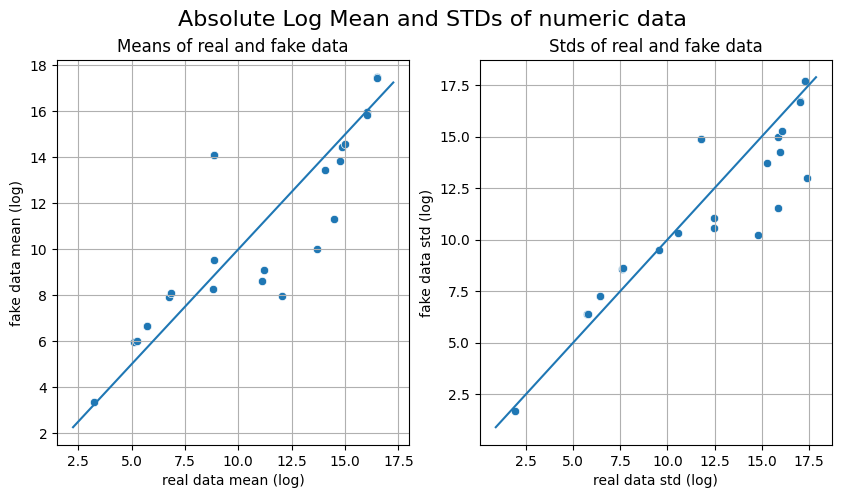

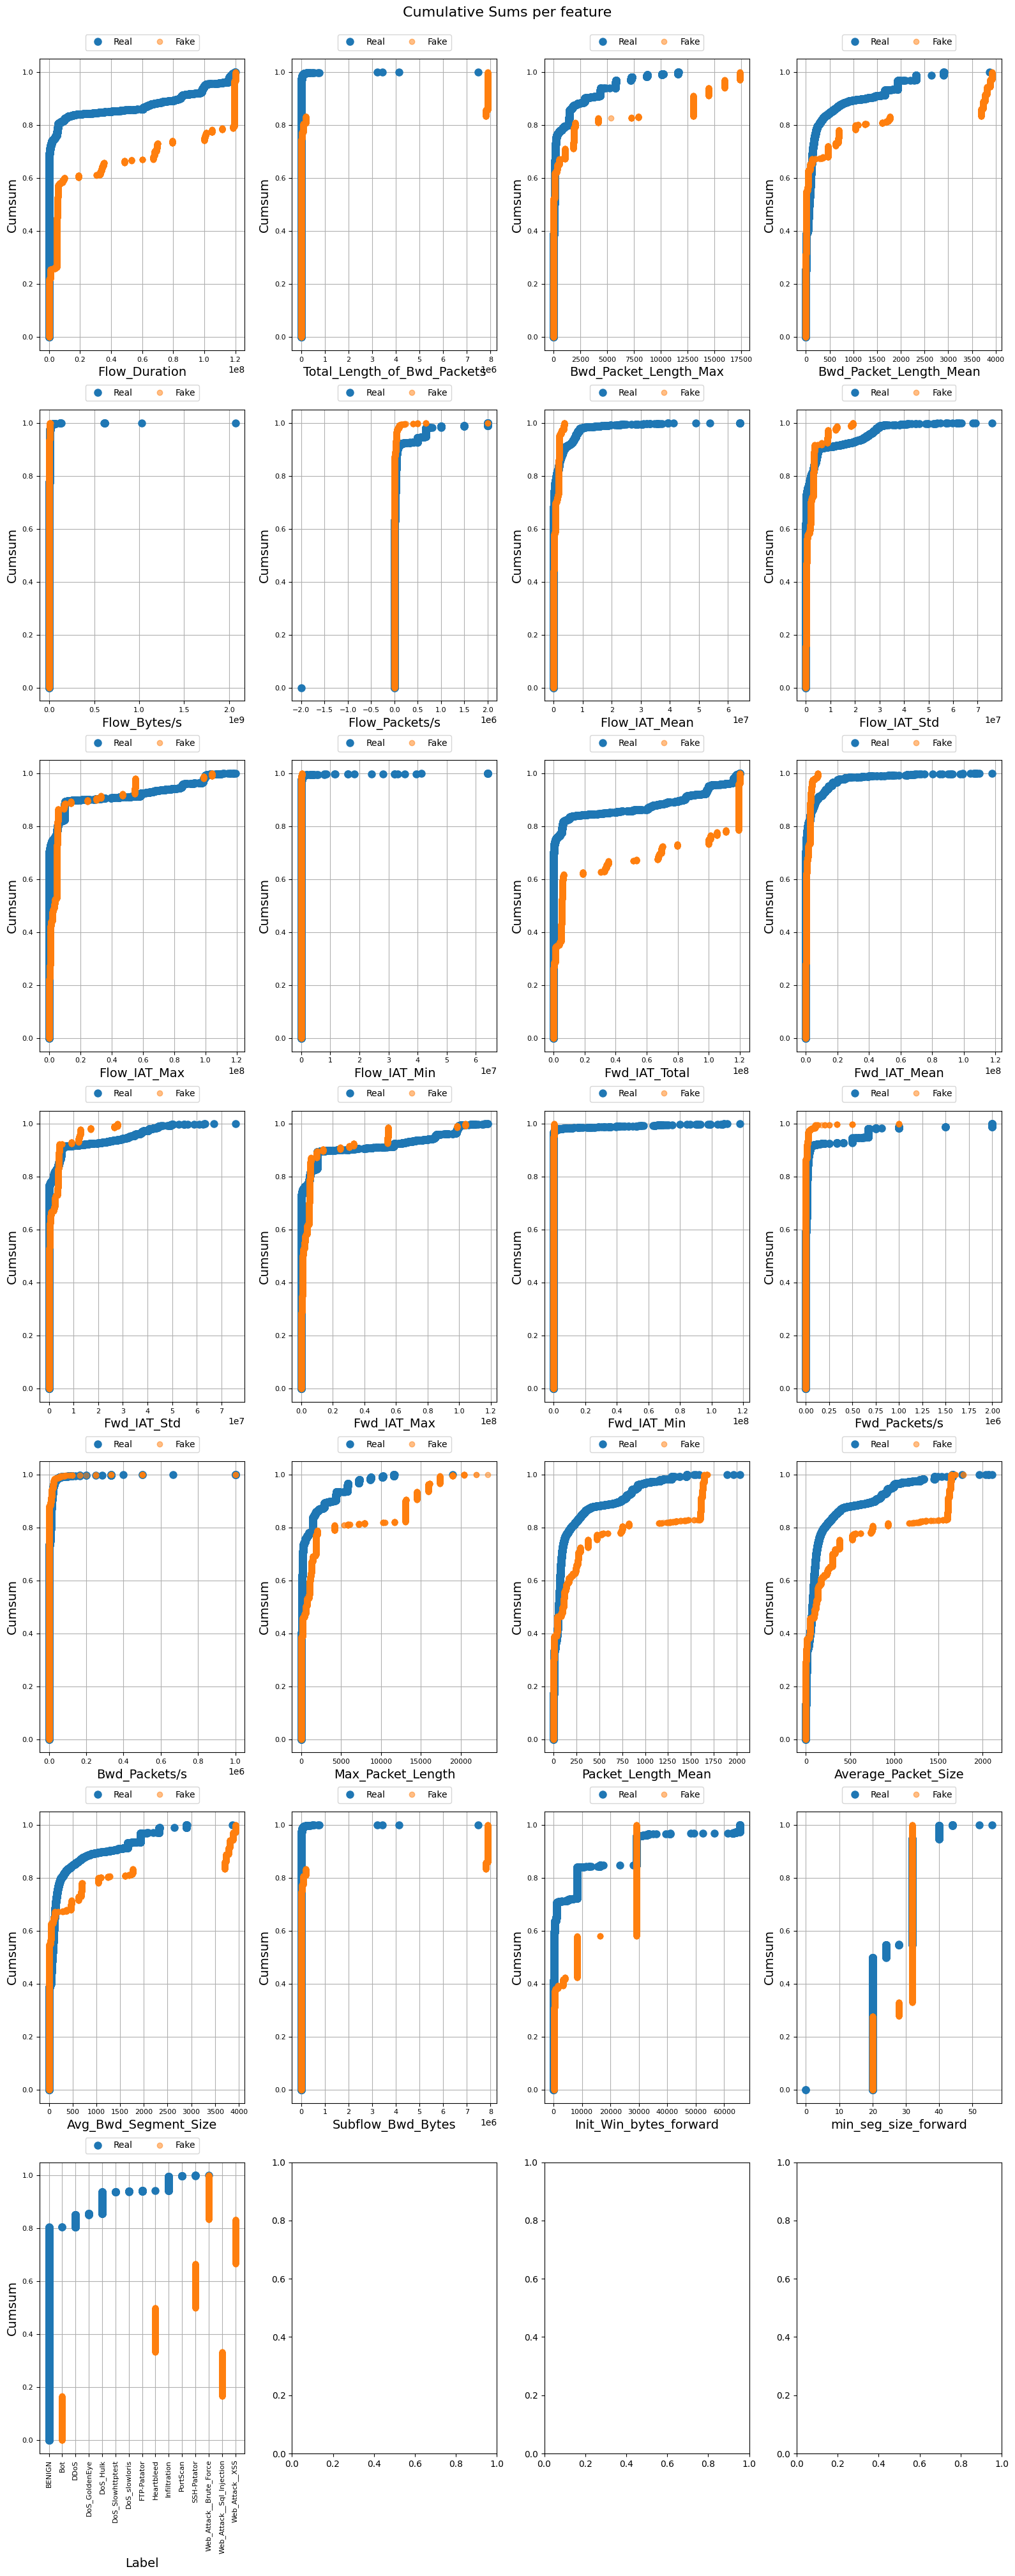


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f35d8b6c8b0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f359a353a60> (for post_execute):



KeyboardInterrupt



In [10]:
ctgan_train(train_df=itu_train_df, epochi=1500, file_name='synthetic_from_itu_ctgan', reduced_test_df=itu_test_df, rounds=1)

In [ ]:
ctgan_train(train_df=itu_train_df, epochi=1500, file_name='synthetic_from_itu_ctgan', reduced_test_df=itu_test_df, rounds=2)

synthetic_from_itu_ctgan epoch=1500 samples=1000 round=3
Generating synthetic data...


Gen. (0.00) | Discrim. (0.00):   0%|                   | 0/1500 [00:00<?, ?it/s]/home/nafi/.local/lib/python3.8/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gen. (-0.89) | Discrim. (-0.30): 100%|██████| 1500/1500 [01:39<00:00, 15.12it/s]
Gen. (0.30) | Discrim. (-0.68): 100%|███████| 1500/1500 [04:04<00:00,  6.12it/s]
Gen. (-3.59) | Discrim. (-1.04): 100%|██████| 1500/1500 [01:21<00:00, 18.34it/s]
Gen. (-1.18) | Discrim. (-2.36): 100%|██████| 1500/1500 [01:24<00:00, 17.66it/s]
Gen. (-4.17) | Discrim. (-1.19): 100%|██████| 1500/1500 [01:24<00:00, 17.85it/s]
Gen. (-0.58) | Discrim. (-0.39): 100%|██████| 1500/1500 [09:06<00:00,  2.75it/s]


Execution time for generating data: 1153.18 seconds
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 1

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  3.5min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.1s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9993    0.9991    0.9992    410865
                      Bot     0.7994    0.7090    0.7515       354
                     DDoS     0.9998    0.9993    0.9995     23160
            DoS_GoldenEye     0.9957    0.9925    0.9941      1861
                 DoS_Hulk     0.9979    0.9977    0.9978     41626
         DoS_Slowhttptest     0.9441    0.9849    0.9641       994
            DoS_slowloris     0.9933    0.9971    0.9952      1048
              FTP-Patator     1.0000    0.9972    0.9986      1436
               Heartbleed     1.0000    1.0000    1.0000         2
             Infiltration     1.0000    0.5000    0.6667         6
                 PortScan     0.9940    0.9995    0.9968     28728
              SSH-Patator     0.9981    0.9934    0.9958      1067
  Web_Attack__Brute_Force     0.7586    0.8088    0.7829       272
Web_Attack__Sql_I

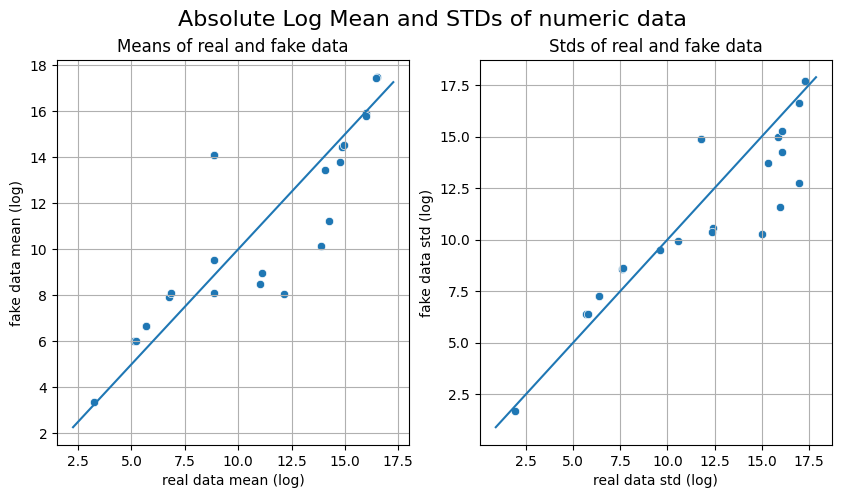

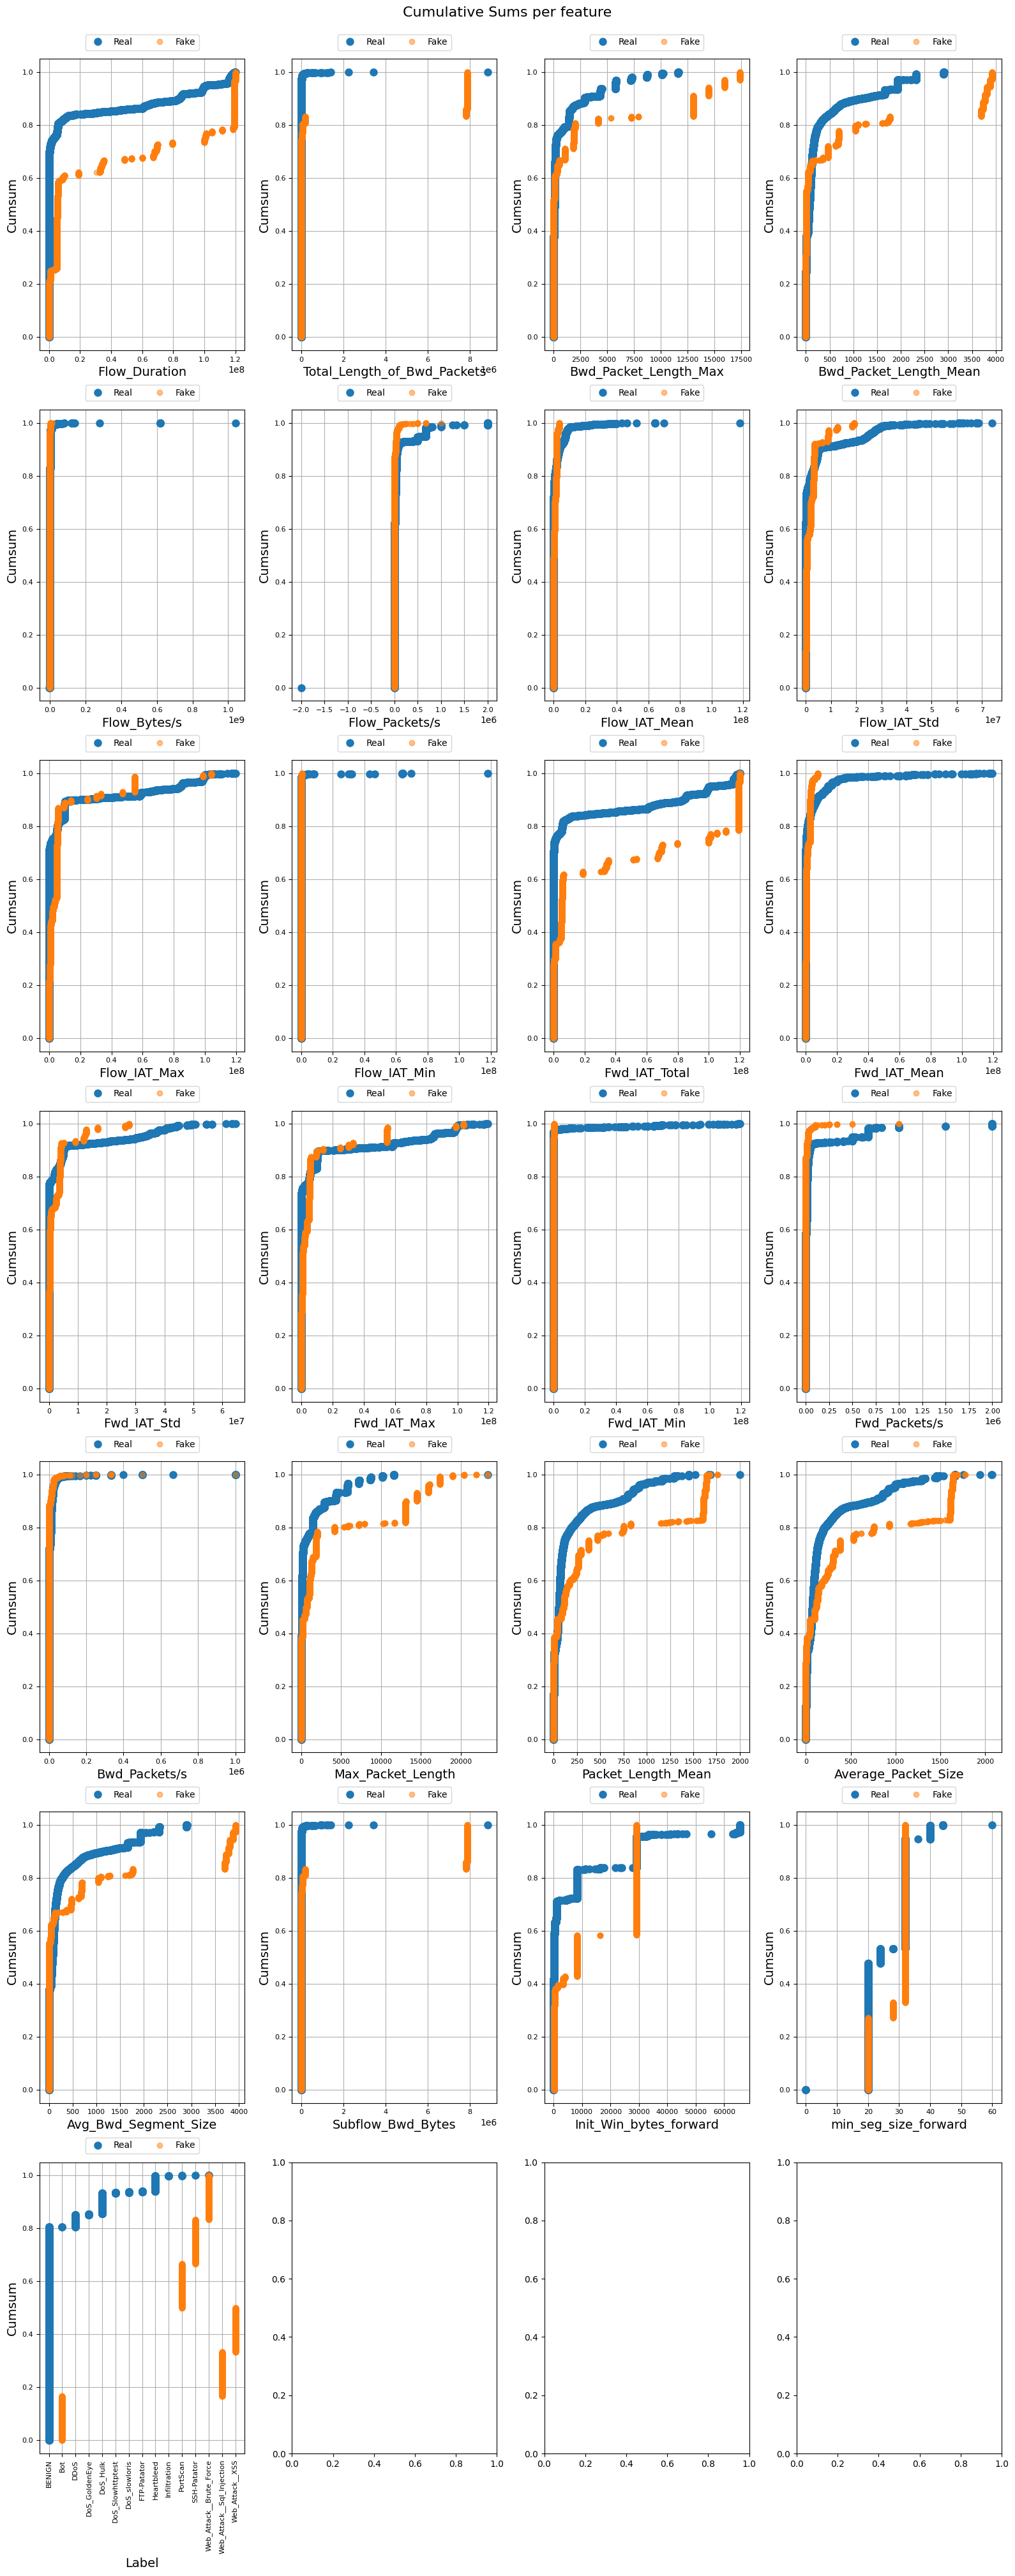

In [ ]:
ctgan_train(train_df=itu_train_df, epochi=1500, file_name='synthetic_from_itu_ctgan', reduced_test_df=itu_test_df, rounds=3)

In [12]:
from scipy.spatial.distance import jensenshannon

small_classes = ['Web_Attack__XSS', 'Web_Attack__Brute_Force',
       'Web_Attack__Sql_Injection', 'Infiltration', 'Heartbleed', 'Bot']

def calculate_emd(real_data, synthetic_data, bins=20):
    emd_scores = {}
    for column in real_data.columns:
        real_hist, bin_edges = np.histogram(real_data[column], bins=bins, density=True)
        synthetic_hist, _ = np.histogram(synthetic_data[column], bins=bin_edges, density=True)
        
        # Avoid division by zero by adding a small value
        real_hist += 1e-8
        synthetic_hist += 1e-8
        
        # Normalize histograms to form probability distributions
        real_prob = real_hist / np.sum(real_hist)
        synthetic_prob = synthetic_hist / np.sum(synthetic_hist)
        
        
        emd_scores[column] = wasserstein_distance(real_prob, synthetic_prob)

    mean_emd = np.mean(list(emd_scores.values()))
    return mean_emd

def calculate_classwise_emd(real_data, synthetic_data):
    emd_store = []
    for cls in small_classes:
        syn = synthetic_data[synthetic_data['Label']==cls].copy()
        real = real_data[real_data['Label']==cls].copy()
        
        syn.drop(columns='Label', inplace=True)
        real.drop(columns='Label', inplace=True)

        emd = calculate_emd(real, syn)
        emd_store.append({cls, emd})
    print("EMD: ", emd_store)
    print(f'Mean: {np.mean([emd for item in emd_store for emd in item if isinstance(emd, (int, float))])}')
    
def calculate_jsd(real_data, synthetic_data, bins=20):
    jsd_scores = {}
    for column in real_data.columns:
        real_hist, bin_edges = np.histogram(real_data[column], bins=bins, density=True)
        synthetic_hist, _ = np.histogram(synthetic_data[column], bins=bins, density=True)
        
        jsd = jensenshannon(real_hist, synthetic_hist)
        
        jsd_scores[column] = jsd

    mean_jsd = np.mean(list(jsd_scores.values()))
    return mean_jsd

def calculate_classwise_jsd(real_data, synthetic_data):
    jsd_store = []
    for cls in small_classes:
        syn = synthetic_data[synthetic_data['Label'] == cls].copy()
        real = real_data[real_data['Label'] == cls].copy()
        
        syn.drop(columns='Label', inplace=True)
        real.drop(columns='Label', inplace=True)

        jsd = calculate_jsd(real, syn)
        jsd_store.append({cls, jsd}) 
    
    print("JSD: ", jsd_store)
    # Extract JSD values from the sets and compute the mean
    jsd_values = [val for item in jsd_store for val in item if isinstance(val, (int, float))]
    print(f'Mean JSD: {np.mean(jsd_values)}')

In [13]:
synthetic_file_path = f"./datasets/synthetic_from_itu_ctgansample1000epoch1500rounds1.csv"
synthetic_data_df = pd.read_csv(synthetic_file_path)
synthetic_data_df["Label"].value_counts()

Label
Web_Attack__XSS              1000
Web_Attack__Brute_Force      1000
Web_Attack__Sql_Injection    1000
Infiltration                 1000
Heartbleed                   1000
Bot                          1000
Name: count, dtype: int64

In [14]:
calculate_classwise_jsd(itu_train_df, synthetic_data_df)

JSD:  [{0.17956178894711292, 'Web_Attack__XSS'}, {0.18837005557261544, 'Web_Attack__Brute_Force'}, {0.07422343077728681, 'Web_Attack__Sql_Injection'}, {0.03931810982538283, 'Infiltration'}, {0.01515014030143654, 'Heartbleed'}, {0.09534184433896321, 'Bot'}]
Mean JSD: 0.0986608949604663
